# TODO Is 32k aac good enough?
- https://trac.ffmpeg.org/wiki/Encode/AAC
- https://trac.ffmpeg.org/wiki/Encode/HighQualityAudio
- https://www.ffmpeg.org/ffmpeg-codecs.html

In [ ]:
from notebooks import *
# memory.log.level = 'debug'  # XXX Debug
sg.init(app=None)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


INFO     [19:22:05.037] [98548]  44 logging_/init_logging: {logging_yaml: None}

INFO     [19:22:05.292] [98548]  28 api.server_globals/init

INFO     [19:22:07.146] [98548]  30 api.server_globals/init: done

In [ ]:
recs = (sg.xc_meta
    [lambda df: df.species.isin(['BLPW'])]
    # .sample(n=3, random_state=0)  # XXX Debug
    .sample(n=5, random_state=0)  # XXX Debug
    # .sample(n=10, random_state=0)  # XXX Debug
    # .sample(n=1000, random_state=0)
    # [lambda df: df.species.isin(['PNLO', 'CARW'])]  # XXX Debug restricted/disabled xc recs
    .pipe(recs_featurize_audio_meta)
)

INFO     [19:22:07.352] [98548] 813 datasets/xc_meta_to_xc_raw_recs: [2/3 slower] Loading xc.metadata -> xc_raw_recs (.audio, more metadata)...

INFO     [19:22:07.368] [98548] 144 load/metadata: {len(recs): 5}

audio_metadata: [

] |   0% Completed |  0.0s

audio_metadata: [

############################################################################

] | 100% Completed |  0.1s

In [ ]:
audio_evals = (
    pd.concat([
        (recs

            [lambda df: df.species.isin(['BLPW'])]
            # .sample(random_state=0,
            #     # n=1,
            #     # n=3,
            #     n=10,
            #     # n=100,
            #     # n=1000,
            # )
            # [lambda df: df.index.isin([178601])]  # BLPW

            # Load .audio
            # .pipe(sg.load.audio, scheduler='threads')
            .pipe(sg.load.audio, use=None)

            # Transcode + persist audio
            .pipe(Load(**audio_kwargs).transcode_audio)

            # Surface .audio_data, for inspection
            .assign(
                audio_data=lambda df: df.audio.map(lambda x: np.frombuffer(x.unbox._data, dtype=np.uint8)),
            )

            # Surface .filesize_b, for inspection
            .assign(
                filesize_b=lambda df: df.audio.map(lambda audio: Path(audio_abs_path(audio.unbox)).stat().st_size),
            )

            # Add .feat, .spectro from transcoded .audio
            .pipe(sg.projection.transform)  # .feat
            .assign(spectro=lambda df: sg.features.spectro(df,  # .spectro is the input for thumb/micro
                scheduler='threads',
                # use=None,
                cache=True,
            ))

            # .pipe(tap, lambda df: pp(df[['path', 'id', 'audio']].T))

            # XXX Slice to zoom
            # .pipe(df_map_rows, lambda rec: sg.features.slice_spectro(rec, 1, 3))

            # Add .thumb from transcoded .spectro, .audio
            .pipe(df_assign_first, **dict(
                thumb=df_cell_spectros(
                    # micro not thumb, else start_s varies with encoding
                    #   - pad=False with plot_spectro_micro, else it's too wide to display at full height (from scale)
                    # plot_thumb.many, thumb_s=5, plot_kwargs=dict(audio_kwargs=dict(
                    plot_spectro_micro.many, limit_s=3, pad=False, audio_kwargs=(dict(
                        # Override config.audio_kwargs (in display_with_audio) to keep the encoding from transcode_audio (above)
                        **audio_kwargs,
                    )),
                    features=sg.features,
                    scale=dict(h=int(40 * 4)),  # (scale)
                    progress=dict(use='dask', scheduler='threads'),
                    # progress=dict(use=None),
                    _nocache=True,  # Dev: disable plot_many cache since it's blind to most of our sub-many code changes
                ),
            ))

            # Drop cols
            #   - .spectro: Trimmed to .micro/.thumb
            #   - .*_stack: Redundant
            .drop(columns=['spectro'])
            [lambda df: [c for c in df if not c.endswith('_stack')]]

            # Cosmetics
            .pipe(df_reorder_cols, first=[
                'thumb', 'id', 'audio_data', 'duration_s', 'audio',
            ])
            .pipe(df_assign_first,
                format=audio_kwargs.get('format', ''),
                bitrate=audio_kwargs.get('bitrate', ''),
                codec=audio_kwargs.get('codec', ''),
            )

        )
        for audio_kwargs in [

            # dict(format='wav'),
            # dict(format='mp3', bitrate='64k'),
            # dict(format='mp4', bitrate='64k',  codec='aac'),
            # dict(format='mp4', bitrate='64k',  codec='libfdk_aac'),

            # dict(format='wav'),
            # dict(format='mp3', bitrate='128k'),
            # dict(format='mp3', bitrate='64k'),
            # dict(format='mp3', bitrate='32k'),
            # dict(format='mp3', bitrate='16k'),
            # dict(format='mp3', bitrate='8k'),
            # dict(format='mp4', bitrate='128k', codec='aac'),
            # dict(format='mp4', bitrate='64k',  codec='aac'),
            # dict(format='mp4', bitrate='32k',  codec='aac'),
            # dict(format='mp4', bitrate='16k',  codec='aac'),
            # dict(format='mp4', bitrate='8k',   codec='aac'),
            # dict(format='mp4', bitrate='128k', codec='libfdk_aac'),
            # dict(format='mp4', bitrate='64k',  codec='libfdk_aac'),
            # dict(format='mp4', bitrate='32k',  codec='libfdk_aac'),
            # dict(format='mp4', bitrate='16k',  codec='libfdk_aac'),
            # dict(format='mp4', bitrate='8k',   codec='libfdk_aac'),

            *notes[['format', 'bitrate', 'codec']].to_dict(orient='records'),

        ]
    ])
)

INFO     [19:22:19.769] [98548] 213 load/audio: {len(recs): 5}

INFO     [19:22:19.802] [98548] 245 load/transcode_audio: {len(recs): 5, audio_config: {should_transcode: true, sample_rate: 22050, channels: 1, sample_width_bit: 16, format: mp4, bitrate: 32k, codec: libfdk_aac}}

transcode_audio: [

] |   0% Completed |  0.0s

transcode_audio: [

] |   0% Completed |  0.2s

transcode_audio: [

] |   0% Completed |  0.3s

transcode_audio: [

] |   0% Completed |  0.4s

transcode_audio: [

] |   0% Completed |  0.5s

transcode_audio: [

] |   0% Completed |  0.6s

transcode_audio: [

] |   0% Completed |  0.7s

transcode_audio: [

] |   0% Completed |  0.8s

transcode_audio: [

] |   0% Completed |  0.9s

transcode_audio: [

] |   0% Completed |  1.0s

transcode_audio: [

] |   0% Completed |  1.1s

transcode_audio: [

] |   0% Completed |  1.2s

transcode_audio: [

] |   0% Completed |  1.3s

transcode_audio: [

] |   0% Completed |  1.4s

transcode_audio: [

] |   0% Completed |  1.5s

transcode_audio: [

] |   0% Completed |  1.6s

transcode_audio: [

] |   0% Completed |  1.7s

transcode_audio: [

] |   0% Completed |  1.8s

transcode_audio: [

] |   0% Completed |  1.9s

transcode_audio: [

] |   0% Completed |  2.1s

transcode_audio: [

] |   0% Completed |  2.2s

transcode_audio: [

] |   0% Completed |  2.3s

transcode_audio: [

] |   0% Completed |  2.4s

transcode_audio: [

] |   0% Completed |  2.5s

transcode_audio: [

] |   0% Completed |  2.6s

transcode_audio: [

] |   0% Completed |  2.7s

transcode_audio: [

] |   0% Completed |  2.8s

transcode_audio: [

] |   0% Completed |  2.9s

transcode_audio: [

] |   0% Completed |  3.0s

transcode_audio: [

] |   0% Completed |  3.1s

transcode_audio: [

] |   0% Completed |  3.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 11.7s

transcode_audio: [

#####################################                                      

] |  50% Completed | 11.8s

transcode_audio: [

#####################################                                      

] |  50% Completed | 11.9s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.0s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.1s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.3s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.4s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.5s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.6s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.7s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.8s

transcode_audio: [

#####################################                                      

] |  50% Completed | 12.9s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.0s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.1s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.3s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.4s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.5s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.6s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.7s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 22.8s

transcode_audio: [

###########################################################################

] | 100% Completed | 23.2s

feat: [

] |   0% Completed |  0.0s

feat: [

######################################################################################

] | 100% Completed |  0.1s

spectro: [

] |   0% Completed |  0.0s

spectro: [

###################################################################################

] | 100% Completed |  0.1s

plot_spectro_micro.many: [

] |   0% Completed |  0.0s

plot_spectro_micro.many: [

] |   0% Completed |  0.1s

plot_spectro_micro.many: [

] |   0% Completed |  0.2s

plot_spectro_micro.many: [

###################################################################

] | 100% Completed |  0.3s

INFO     [19:22:44.143] [98548] 213 load/audio: {len(recs): 5}

INFO     [19:22:44.188] [98548] 245 load/transcode_audio: {len(recs): 5, audio_config: {should_transcode: true, sample_rate: 22050, channels: 1, sample_width_bit: 16, format: wav, bitrate: '', codec: ''}}

transcode_audio: [

] |   0% Completed |  0.0s

transcode_audio: [

] |   0% Completed |  0.2s

transcode_audio: [

] |   0% Completed |  0.3s

transcode_audio: [

] |   0% Completed |  0.4s

transcode_audio: [

] |   0% Completed |  0.5s

transcode_audio: [

] |   0% Completed |  0.6s

transcode_audio: [

] |   0% Completed |  0.7s

transcode_audio: [

] |   0% Completed |  0.8s

transcode_audio: [

] |   0% Completed |  0.9s

transcode_audio: [

] |   0% Completed |  1.0s

transcode_audio: [

] |   0% Completed |  1.1s

transcode_audio: [

] |   0% Completed |  1.2s

transcode_audio: [

] |   0% Completed |  1.3s

transcode_audio: [

] |   0% Completed |  1.4s

transcode_audio: [

] |   0% Completed |  1.5s

transcode_audio: [

] |   0% Completed |  1.6s

transcode_audio: [

] |   0% Completed |  1.7s

transcode_audio: [

] |   0% Completed |  1.8s

transcode_audio: [

] |   0% Completed |  1.9s

transcode_audio: [

] |   0% Completed |  2.0s

transcode_audio: [

] |   0% Completed |  2.1s

transcode_audio: [

] |   0% Completed |  2.2s

transcode_audio: [

] |   0% Completed |  2.3s

transcode_audio: [

] |   0% Completed |  2.4s

transcode_audio: [

] |   0% Completed |  2.5s

transcode_audio: [

] |   0% Completed |  2.7s

transcode_audio: [

] |   0% Completed |  2.8s

transcode_audio: [

] |   0% Completed |  2.9s

transcode_audio: [

] |   0% Completed |  3.0s

transcode_audio: [

] |   0% Completed |  8.8s

transcode_audio: [

] |   0% Completed | 11.3s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.0s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.1s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.3s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.4s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.5s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.6s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.7s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.8s

transcode_audio: [

#####################################                                      

] |  50% Completed | 13.9s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.0s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.1s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.3s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.4s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.6s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.7s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.8s

transcode_audio: [

#####################################                                      

] |  50% Completed | 14.9s

transcode_audio: [

#####################################                                      

] |  50% Completed | 15.0s

transcode_audio: [

#####################################                                      

] |  50% Completed | 15.1s

transcode_audio: [

#####################################                                      

] |  50% Completed | 15.2s

transcode_audio: [

#####################################                                      

] |  50% Completed | 15.3s

transcode_audio: [

#####################################                                      

] |  50% Completed | 15.4s

transcode_audio: [

#####################################                                      

] |  50% Completed | 15.5s

transcode_audio: [

#####################################                                      

] |  50% Completed | 16.4s

transcode_audio: [

#####################################                                      

] |  50% Completed | 21.3s

transcode_audio: [

###########################################################################

] | 100% Completed | 21.6s

feat: [

] |   0% Completed |  0.0s

feat: [

#################                                                                     

] |  20% Completed |  0.1s

feat: [

###################################################                                   

] |  60% Completed |  0.2s

feat: [

###################################################                                   

] |  60% Completed |  0.3s

feat: [

####################################################################                  

] |  80% Completed |  0.4s

feat: [

####################################################################                  

] |  80% Completed |  0.5s

feat: [

####################################################################                  

] |  80% Completed |  0.6s

feat: [

######################################################################################

] | 100% Completed |  0.7s

spectro: [

] |   0% Completed |  0.0s

spectro: [

#################################                                                  

] |  40% Completed |  0.1s

spectro: [

##################################################################                 

] |  80% Completed |  0.2s

spectro: [

###################################################################################

] | 100% Completed |  0.3s

INFO     [19:23:07.954] [98548] 487 load/_transcode_audio: Write: cache/audio/xc/data/BLPW/79512/audio.mp3.resample(22050,1,16).enc(wav).slice(0,3000).enc(wav)

plot_spectro_micro.many: [

] |   0% Completed |  0.0s

plot_spectro_micro.many: [

] |   0% Completed |  0.1s

INFO     [19:23:08.159] [98548] 487 load/_transcode_audio: Write: cache/audio/xc/data/BLPW/317729/audio.mp3.resample(22050,1,16).enc(wav).slice(0,3000).enc(wav)

INFO     [19:23:08.171] [98548] 487 load/_transcode_audio: Write: cache/audio/xc/data/BLPW/322816/audio.mp3.resample(22050,1,16).enc(wav).slice(0,3000).enc(wav)

INFO     [19:23:08.188] [98548] 487 load/_transcode_audio: Write: cache/audio/xc/data/BLPW/178837/audio.mp3.resample(22050,1,16).enc(wav).slice(0,3000).enc(wav)

plot_spectro_micro.many: [

###################################################################

] | 100% Completed |  0.2s

In [ ]:
# HACK Have to run this before previous cell
notes = DF([
    # dict(format='mp3', bitrate='8k',                       notes='hi freqs clipped'),
    # dict(format='mp4', bitrate='8k',   codec='libfdk_aac', notes='hi freqs clipped'),
    # dict(format='mp4', bitrate='8k',   codec='aac',        notes='hi freqs clipped'),
    # dict(format='mp3', bitrate='16k',                      notes='hi freqs clipped'),
    # dict(format='mp4', bitrate='16k',  codec='libfdk_aac', notes='hi freqs clipped'),
    # dict(format='mp4', bitrate='16k',  codec='aac',        notes='hi freqs clipped'),
    # dict(format='mp3', bitrate='32k',                      notes='hi freqs clipped (barely)'),
    dict(format='mp4', bitrate='32k',  codec='libfdk_aac', notes='very hard to tell vs. wav!'),
    # dict(format='mp4', bitrate='32k',  codec='aac',        notes='worse than libfdk_aac(32k)'),
    # dict(format='mp3', bitrate='64k',                      notes=''),
    # dict(format='mp4', bitrate='64k',  codec='libfdk_aac', notes=''),
    # dict(format='mp4', bitrate='64k',  codec='aac',        notes=''),
    # dict(format='mp3', bitrate='128k',                     notes='great quality'),
    # dict(format='mp4', bitrate='128k', codec='libfdk_aac', notes='great quality'),
    # dict(format='mp4', bitrate='128k', codec='aac',        notes='great quality'),
    dict(format='wav',                                     notes='baseline'),
]).fillna('')

,xc_id,duration_s,filesize_b,format,bitrate,codec,notes,thumb,id,audio_data,audio,dataset,species,species_com_name,species_query,samples_mb,samples_n,basename,species_longhand,path,feat,channels,sample_rate,sample_width_bit,downloaded,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download,remarks,bird_seen,playback_used,elevation,background,volume,speed,pitch,length,number_of_notes,variable,xc_channels,xc_sampling_rate,xc_bitrate_of_mp3,state_only,place_only,state,place,year,month,month_day,hour,background_species,n_background_species
0,79512,42.0,173233,mp4,32,libfdk_aac,,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->","cache/audio/xc/data/BLPW/79512/audio.mp3.resample(22050,1,16).enc(wav).enc(mp4,libfdk_aac,32k)",[0 0 0 ... 0 0 0],"box(unbox=cache/audio/xc/data/BLPW/79512/audio.mp3.resample(22050,1,16).enc(wav).enc(mp4,libfdk_aac,32k): 1 channels, 16 bit, sampled @ 22.05 kHz, 42.075s long)",xc,BLPW,Blackpoll Warbler,BLPW,3.85,2018304,audio.mp3,Blackpoll Warbler - BLPW,xc/data/BLPW/79512/audio.mp3,[-2.943e-02 2.154e-01 -4.581e-02 -4.162e-02 3.270e-01 -3.829e-01 1.199e-03 7.618e-03 7.633e-02 -4.851e-01 -2.987e-01 2.659e+00 4.198e-01 -1.392e-01 1.672e+00 -1.418e-01 2.440e-01 -3.714e-...,1,48000,16,True,,Andrew Spencer,United States,"Saddleback Mountain, Franklin Co., Maine",44.9,-70.5,song,A,2011-05-31 00:00:00,05:30,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/79512,//www.xeno-canto.org/79512/download,natural vocalization,None,None,800 m,[],Not specified,Not specified,Not specified,Not specified,Not specified,Not specified,1 (mono),48000 (Hz),192000 (bps),Maine,"Saddleback Mountain, Franklin Co.","Maine, United States","Saddleback Mountain, Franklin Co., Maine, United States",2011,5,05-31,5,[],0
5,79512,42.0,1854360,wav,,,baseline,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->","cache/audio/xc/data/BLPW/79512/audio.mp3.resample(22050,1,16).enc(wav)",[255 255 1 ... 0 0 0],"box(unbox=cache/audio/xc/data/BLPW/79512/audio.mp3.resample(22050,1,16).enc(wav): 1 channels, 16 bit, sampled @ 22.05 kHz, 42.048s long)",xc,BLPW,Blackpoll Warbler,BLPW,3.85,2018304,audio.mp3,Blackpoll Warbler - BLPW,xc/data/BLPW/79512/audio.mp3,[-2.774e-02 1.647e-01 -1.376e-02 -3.333e-02 1.356e-01 -3.637e-01 -4.915e-03 -2.789e-02 1.801e-02 -4.097e-01 -1.499e-01 2.009e+00 3.075e-01 5.191e-02 1.262e+00 -1.556e-01 2.423e-01 -3.724e-...,1,48000,16,True,,Andrew Spencer,United States,"Saddleback Mountain, Franklin Co., Maine",44.9,-70.5,song,A,2011-05-31 00:00:00,05:30,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/79512,//www.xeno-canto.org/79512/download,natural vocalization,None,None,800 m,[],Not specified,Not specified,Not specified,Not specified,Not specified,Not specified,1 (mono),48000 (Hz),192000 (bps),Maine,"Saddleback Mountain, Franklin Co.","Maine, United States","Saddleback Mountain, Franklin Co., Maine, United States",2011,5,05-31,5,[],0
2,160575,32.0,132359,mp4,32,libfdk_aac,,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->","cache/audio/xc/data/BLPW/160575/audio.mp3.resample(22050,1,16).enc(wav).enc(mp4,libfdk_aac,32k)",[ 0 0 0 ... 255 1 0],"box(unbox=cache/audio/xc/data/BLPW/160575/audio.mp3.resample(22050,1,16).enc(wav).enc(mp4,libfdk_aac,32k): 1 channels, 16 bit, sampled @ 22.05 kHz, 32.044s long)",xc,BLPW,Blackpoll Warbler,BLPW,2.93,1537920,audio.mp3,Blackpoll Warbler - BLPW,xc/data/BLPW/160575/audio.mp3,[ 1.465e-02 -1.682e-02 2.862e-01 -7.395e-02 -4.092e-02 -1.128e-01 8.870e-05 4.603e-03 4.227e-02 -5.661e-02 -6.419e-02 1.817e-01 -9.363e-02 9.985e-02 1.643e-01 -1.624e-01 1.873e-01 1.710e-...,1,48000,16,True,,Ian Cruickshank,Canada,"3 km south of Fishing Lake, SK",51.8,-104.0,song,B,2013-05-25 00:00:00,06:40,by-nc-nd,3.0,//creativecommons.org/licenses/by-nc-nd/3.0/,https://www.xeno-canto.org/160575
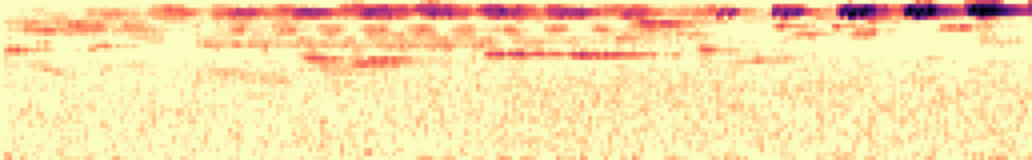
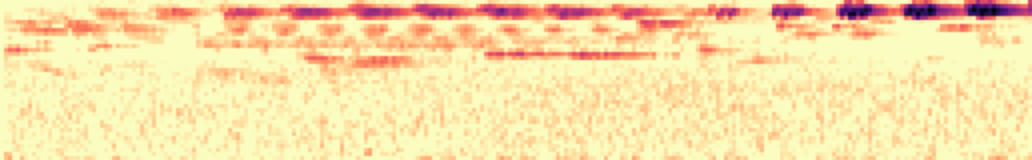
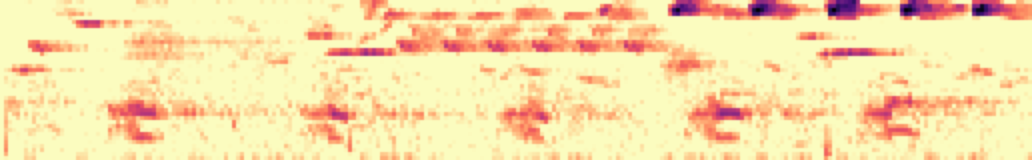
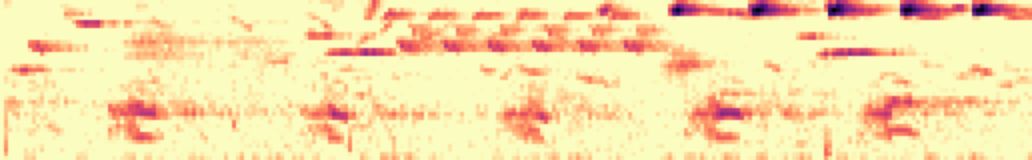
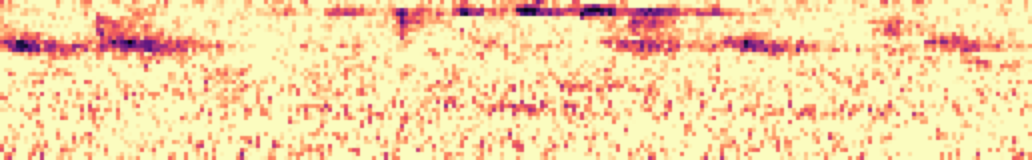
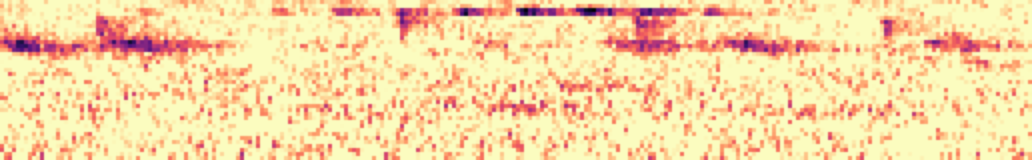
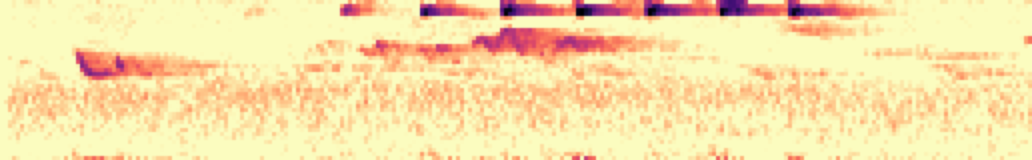
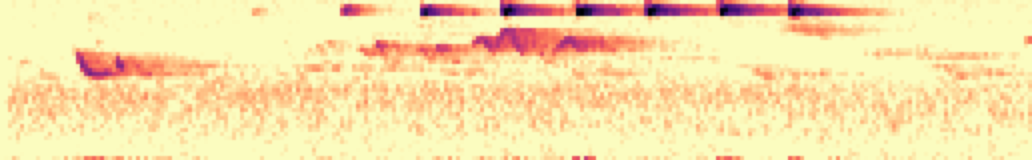
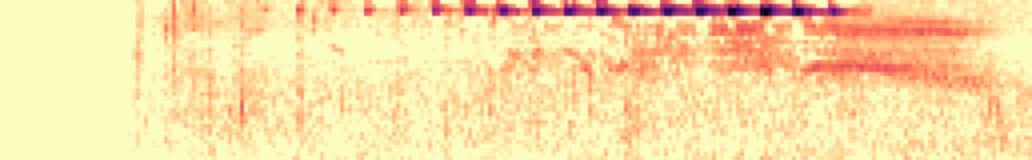
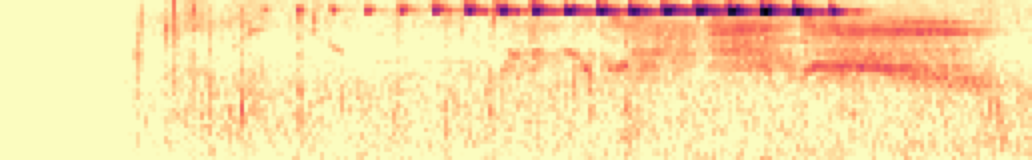

In [ ]:
(notes
    .merge(right=audio_evals.reset_index(), how='left', on=['format', 'bitrate', 'codec'])
    .pipe(df_col_map, bitrate=lambda x: x and int(x[:-1]))  # str -> int, for sort
    .pipe(df_reorder_cols, first=['xc_id', 'duration_s', 'filesize_b', 'format', 'bitrate', 'codec', 'notes', 'thumb', 'id', 'audio_data'])
    .sort_values(['xc_id'], kind='mergesort')  # mergesort for stable sort
    # .sort_values(['xc_id', 'filesize_b', 'format', 'bitrate'], kind='mergesort')  # mergesort for stable sort
    # [lambda df: df.format.isin(['mp3', 'wav'])]
    # [lambda df: df.bitrate.isin([32, ''])]
)